In [1]:
# Feature Selection
from pandas import DataFrame, Index, read_csv
from dslabs_functions import (
    select_low_variance_variables,
    study_variance_for_feature_selection,
    apply_feature_selection,
    select_redundant_variables,
    study_redundancy_for_feature_selection,
)


def select_low_variance_variables(
    data: DataFrame, max_threshold: float, target: str = "class"
) -> list:
    summary5: DataFrame = data.describe()
    vars2drop: Index[str] = summary5.columns[
        summary5.loc["std"] * summary5.loc["std"] < max_threshold
    ]
    vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop
    return list(vars2drop.values)


target = "Churn"
file_tag = "churn_feature_selection"
#filename = "C:\\Users\\LENOVO\\Documents\\Projetos\\Data_science\\data_science\\data\\churn_truncate_outliers.csv"
filename = "C:\\Users\\LENOVO\\Documents\\Projetos\\Data_science\\data_science\\data\\churn_scaled_minmax.csv"
train: DataFrame = read_csv(filename, index_col = "Unnamed: 0")
train = train.head(5000)
#print(train.tail(10))
#print(train.describe())

print("Original variables", train.columns.to_list())
vars2drop: list[str] = select_low_variance_variables(train, 3, target=target)
print("Variables to drop", vars2drop)

Original variables ['tenure', 'InternetService', 'PaymentMethod', 'MonthlyCharges', 'Cost/service', 'SecurityCost', 'StreamingCost', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'Churn']
Variables to drop ['tenure', 'InternetService', 'PaymentMethod', 'MonthlyCharges', 'Cost/service', 'SecurityCost', 'StreamingCost', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year']


In [11]:
filename = "C:\\Users\\LENOVO\\Documents\\Projetos\\Data_science\\data_science\\data\\churn_scaled_minmax.csv"
test: DataFrame = read_csv(filename, index_col = "Unnamed: 0")
print(test.tail(10))

        tenure  InternetService  PaymentMethod  MonthlyCharges  Cost/service  \
7029  0.083333              0.5       0.333333        0.263609      0.054242   
7030  0.027778              0.0       0.000000        0.018145      0.019910   
7032  0.013889              1.0       0.333333        0.579637      0.009986   
7033  0.527778              1.0       1.000000        0.516633      0.612390   
7035  0.263889              1.0       0.666667        0.609375      0.257038   
7036  0.166667              0.5       0.333333        0.427419      0.097465   
7037  1.000000              0.0       0.666667        0.029234      0.998228   
7038  0.333333              0.5       0.000000        0.670867      0.227248   
7040  0.152778              0.5       0.333333        0.114415      0.114878   
7041  0.055556              1.0       0.000000        0.566028      0.064532   

      SecurityCost  StreamingCost  TotalCharges  gender  SeniorCitizen  ...  \
7029      0.000000       0.092217      0

In [13]:
#Figure 27
from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, evaluate_approach, plot_multiline_chart


def study_variance_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    max_threshold: float = 1,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(i * lag, 3) for i in range(1, ceil(max_threshold / lag + lag))
    ]
    results: dict[str, list] = {"NB": [], "KNN": []}
    summary5: DataFrame = train.describe()
    for thresh in options:
        vars2drop: Index[str] = summary5.columns[
            summary5.loc["std"] * summary5.loc["std"] < thresh
        ]
        vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict[str, list] | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} variance study ({metric})",
        xlabel="variance threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_low_var_{metric}_study.png")
    return results


eval_metric = "recall"
filename = "C:\\Users\\LENOVO\\Documents\\Projetos\\Data_science\\data_science\\data\\churn_scaled_minmax.csv"
dataset: DataFrame = read_csv(filename, index_col = "Unnamed: 0")
train = dataset.head(5000)
test = dataset.tail(1000)
file_tag = "29_churn"

figure(figsize=(2 * HEIGHT, HEIGHT))
study_variance_for_feature_selection(
    train,
    test,
    target=target,
    max_threshold=3,
    lag=0.1,
    metric=eval_metric,
    file_tag=file_tag,
)
show()

ValueError: Found array with 0 feature(s) (shape=(5000, 0)) while a minimum of 1 is required by GaussianNB.

<Figure size 1200x600 with 0 Axes>

In [7]:
from pandas import Series


def select_redundant_variables(
    data: DataFrame, min_threshold: float = 0.90, target: str = "class"
) -> list:
    df: DataFrame = data.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)
        if len(vars_corr) > 1:
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)
    return vars2drop


print("Original variables", train.columns.values)
vars2drop: list[str] = select_redundant_variables(
    train, target=target, min_threshold=0.65
)
print("Variables to drop", vars2drop)

Original variables ['tenure' 'InternetService' 'PaymentMethod' 'MonthlyCharges'
 'Cost/service' 'SecurityCost' 'StreamingCost' 'TotalCharges' 'gender'
 'SeniorCitizen' 'Partner' 'Dependents' 'PhoneService' 'MultipleLines'
 'OnlineSecurity' 'OnlineBackup' 'DeviceProtection' 'TechSupport'
 'StreamingTV' 'StreamingMovies' 'Contract_Month-to-month'
 'Contract_One year' 'Contract_Two year' 'Churn']
Variables to drop ['Cost/service', 'TotalCharges', 'tenure', 'StreamingTV', 'StreamingMovies', 'SecurityCost', 'StreamingCost']


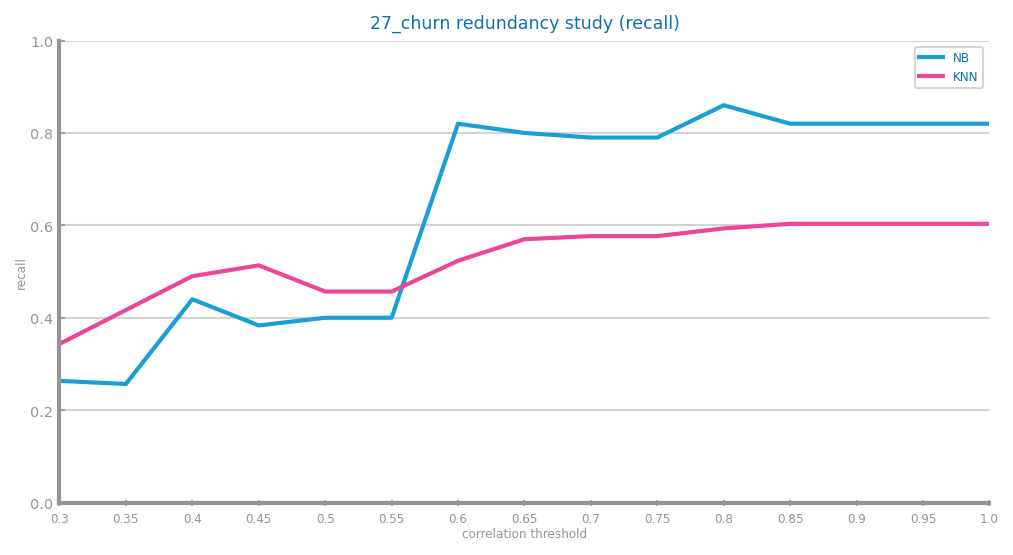

In [5]:
def study_redundancy_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(min_threshold + i * lag, 3)
        for i in range(ceil((1 - min_threshold) / lag) + 1)
    ]

    df: DataFrame = train.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    results: dict[str, list] = {"NB": [], "KNN": []}
    for thresh in options:
        vars2drop: list = []
        for v1 in variables:
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            vars_corr.drop(v1, inplace=True)
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} redundancy study ({metric})",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_redundancy_{metric}_study.png")
    return results


eval_metric = "recall"
#test: DataFrame = read_csv("C:\\Users\\LENOVO\\Documents\\Projetos\\Data_science\\data_science\\data\\churn_truncate_outliers.csv", index_col = "Unnamed: 0")
#train = test.head(5000)
#test = test.tail(1000)
file_tag = "27_churn"

figure(figsize=(2 * HEIGHT, HEIGHT))
study_redundancy_for_feature_selection(
    train,
    test,
    target=target,
    min_threshold=0.3,
    lag=0.05,
    metric=eval_metric,
    file_tag=file_tag,
)
show()

In [8]:
vars2drop: list[str] = select_redundant_variables(
    train, min_threshold=0.65, target=target
)
file_tag = "churn_feature_selection_"
train_cp, test_cp = apply_feature_selection(
    train, test, vars2drop, filename=f"data/{file_tag}", tag="redundant"
)
print(f"Original data: train={train.shape}, test={test.shape}")
print(f"After redundant FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")


Original data: train=(5000, 24), test=(1000, 24)
After redundant FS: train_cp=(5000, 17), test_cp=(1000, 17)


Minority class= 1 : 1753
Majority class= 0 : 4167
Proportion: 0.42 : 1


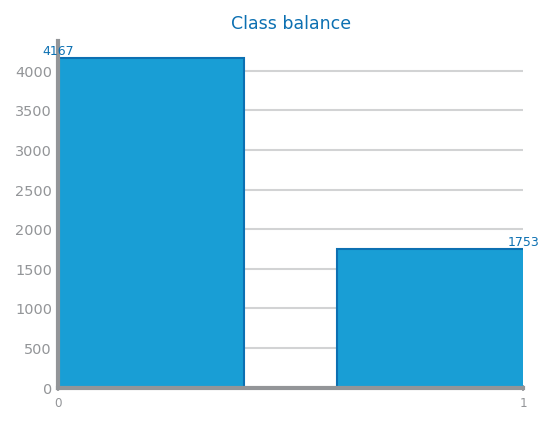

In [21]:
# Figure 25 - Data Preparation - Balance

from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart

file = "churn_"
target = "Churn"
filename = "C:\\Users\\LENOVO\\Documents\\Projetos\\Data_science\\data_science\\data\\churn_scaled_minmax.csv"
original: DataFrame = read_csv(filename, sep=",", decimal=".")

target_count: Series = original[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
savefig(f"images/25_{file_tag}_prep_balance_study_before.png")
show()

In [22]:
df_positives: Series = original[original[target] == positive_class]
df_negatives: Series = original[original[target] == negative_class]

In [23]:
df_neg_sample: DataFrame = DataFrame(df_negatives.sample(len(df_positives)))
df_under: DataFrame = concat([df_positives, df_neg_sample], axis=0)
df_under.to_csv(f"data/{file}_under.csv", index=False)

print("Minority class=", positive_class, ":", len(df_positives))
print("Majority class=", negative_class, ":", len(df_neg_sample))
print("Proportion:", round(len(df_positives) / len(df_neg_sample), 2), ": 1")

Minority class= 1 : 1753
Majority class= 0 : 1753
Proportion: 1.0 : 1


In [24]:
df_pos_sample: DataFrame = DataFrame(
    df_positives.sample(len(df_negatives), replace=True)
)
df_over: DataFrame = concat([df_pos_sample, df_negatives], axis=0)
df_over.to_csv(f"data/{file}_over.csv", index=False)

print("Minority class=", positive_class, ":", len(df_pos_sample))
print("Majority class=", negative_class, ":", len(df_negatives))
print("Proportion:", round(len(df_pos_sample) / len(df_negatives), 2), ": 1")

Minority class= 1 : 4167
Majority class= 0 : 4167
Proportion: 1.0 : 1


In [25]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
y = original.pop(target).values
X: ndarray = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote: DataFrame = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [target]
df_smote.to_csv(f"data/{file}_smote.csv", index=False)

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)

Minority class= 1 : 4167
Majority class= 0 : 4167
Proportion: 1.0 : 1
(8334, 25)


Minority class= 0 : 4167
Majority class= 0 : 4167
Proportion: 1.0 : 1


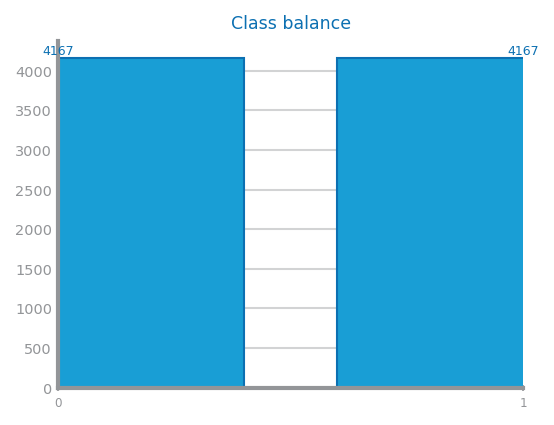

In [20]:
# Figure 25 - Data Preparation - Balance - AFTER

from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart

file = "churn_"
target = "Churn"
filename = "C:\\Users\\LENOVO\\Documents\\Projetos\\Data_science\\data_science\\data\\churn__smote.csv"
original: DataFrame = read_csv(filename, sep=",", decimal=".")

target_count: Series = original[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
savefig(f"images/25_{file_tag}_prep_balance_study_after.png")
show()